# 강남구에서 거래된 전세데이터를 활용하여 전세가가격 예측
## 강남구 전세에 영향을 주는 공시적 변수고려 

![](https://insightimi.files.wordpress.com/2020/07/on-de793_201909_g_20190830121038.gif)

# Content <a id = "cont"></a>
- [서론](#1)
- [Dataset](#2)
    - [데이터수집](#2a)
- [EDA & 데이터 시각화](#3)
    - [데이터 전처리](#3a)
    - [feature Analysis](#3b)
    - [상관관계 분석](#3c)
- [모델링](#4)
    - [Running Basic Algorithms.](#4a)
    - [모델선택](#4b)
    - [교차검증](#4c)
    - [XGboost](#4d)
    - [하이퍼파라미터 튜닝](#4e)
- [결론](#5)

# 서론 <a id = "1"> </a>
- 서울에 내 집 마련하는 것에 대한 로망이 있다. 
- 하지만 이는 쉽지않다. 뉴스에서는 서울서 내 집 마련하는데 18.4년 걸린다한다.(ㅜㅜ)
- 살 수 없는 이들은 전세를 알아본다. 
- 조금이나마 집값에 대한 인사이트를 얻고자 EDA와 그에 따른 MLP 모델을 빌드해보려한다.

**[2018~2022 서울 강남구 부동산 전세 계약 데이터를 통해 찾아온 매물 중 적정 전세 제시]**
- 특징: 금리, 코스피, 공시적변수(인프라데이터: 스타벅스지점수, 미쉐린음식점지점수, 맥도날드지점수, 대규모점포개수, 금리, 전통시장 개수, 역세권 개수)

> 서론과정에서 기획발표를 위해 간단히 만든 ppt <br>
https://gamma.app/docs/4-dx1grkzxodc4z0t?mode=doc

# Dataset <a id = "2"> </a>
## 1. 데이터수집
### 1-1 부동산 거래 데이터 수집
2018-01-01 ~ 2023-12-01 기간의 서울 강남구 전세 계약 건수를 취합
- 국토교통부 실거래가 공개시스템 (http://rtdown.molit.go.kr/)
     - 아파트(전세): 9472건
     - 단독/다가구(전세): 53963건
     - 연립다세대(전세): 15781건
     - 오피스텔(전세): 8145건
### 1-2 금융 feature
주택담보대출금리 추가
- 한국은행 경제 통계 시스템 (https://houstat.hf.go.kr/research/portal/theme/indexStatPage.do)

### 1-3 인프라 feature
주소에 가까운 스타벅스, 미쉐린음식점, 맥도날드, 대형마트, 백화점, 전통시장, 역세권을 추가 
- 서울교통공사 1, 8호선 역사 좌표 (https://www.data.go.kr/data/15099316/fileData.do?recommendDataYn=Y)
- 서울시 대규모점포 인허가 정보 (http://data.seoul.go.kr/dataList/OA-16096/A/1/datasetView.do;jsessionid=42EF715F85DF1A875B6C3C0992A448FA.new_portal-svr-11)
- 서울시 휴게음식점 인허가 정보 (http://data.seoul.go.kr/dataList/OA-16095/S/1/datasetView.do)
- 서울시 강남구 유치원 정보 (http://data.seoul.go.kr/dataList/OA-20601/S/1/datasetView.do;jsessionㅌid=68D0A7FE460F8001FF878FA3ADAA203F.new_portal-svr-21)

# EDA & 데이터시각화 <a id = "3"> </a>

## 2. 데이터전처리 <a id = "3a">
- 쓰레기를 넣으면 쓰레기가 나온다는 것은 데이터 분석의 기본 전제다.
- 올바른 분석 결과를 얻기 위해서는 올바른 데이터를 입력해야하므로, 우수한 분석 알고리즘을 설계하는 것만큼이나 충분히 가다듬어진 데이터를 확보하는 것이 중요하다. 
- 정제된 데이터가 확보되지 않으면 왜곡된 분석결과가 나올 수 있다.
- '서울강남구 전세 계약 건수'를 원본데이터로 중심을 잡고 사용할 feautre만 남겼다. 
- 이후 이 원본데이터에 feature를 추가하는 방식으로 데이터를 추가했다.

### 2-1. 경도 위도 구하기
- 우리조는 경도 위도가 있는 데이터가 필요했다. 하지만 이와 같은 데이터는 극소수였고 대부분 경도 위도를 직접 구해야했다.
- 직접 파이썬 코드로 구현했다. 코드는 아래와 같다.

> geopy.gecoders 라이브러리에서 Nominatim을 호출하였다. 이는 지리위치를 검색하는 데 사용되는 클래스다.
주어진 csv파일에 있는 데이터프레임의 도로명주소를 기반으로 해당 주소의 위도와 경도를 추출하여 csv로 저장한다.
 


In [ ]:
import pandas as pd
from tqdm import tqdm
from geopy.geocoders import Nominatim

# Load CSV file
csv = pd.read_csv('교습소정보.csv')

# Extract addresses
address = csv['도로명주소']

# Clean up addresses
for i in tqdm(range(len(address)), desc="Cleaning Addresses"):
    a = address[i].split(' ')
    address[i] = " ".join(a[0:4])

# Create a geolocator
geo_local = Nominatim(user_agent='South Korea')

# Function to get latitude and longitude
def geocoding(address):
    try:
        geo = geo_local.geocode(address)
        x_y = [geo.latitude, geo.longitude]
        return x_y
    except:
        return [0, 0]

# Geocode addresses and create latitude and longitude lists
latitude = []
longitude = []

for i in tqdm(address, desc="Geocoding Addresses"):
    lat, long = geocoding(i)
    latitude.append(lat)
    longitude.append(long)

# Create a DataFrame
address_df = pd.DataFrame({
    '학원명': csv['학원명'],
    '도로명주소': csv['도로명주소'],
    '주소': address,
    '위도': latitude,
    '경도': longitude
})

# Save the DataFrame
address_df.to_csv('교습소경도위도.csv', index=False)


### 2-2. geopy를 활용한 경도위도 거리구하기
- 우리가 선택한 대부분의 데이터는 경도와 위도가 있는 데이터이다. 아무래도 부동산 데이터이기 때문에 위치가 중요했다.
- 위경도 좌표가 주어져있고 이를 활용해 거리를 구하기 위해 하버사인 공식을 활용했다.
## 하버사인 공식
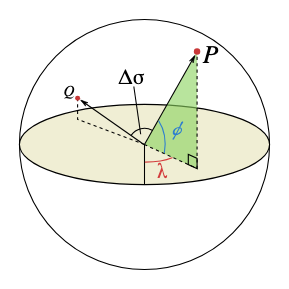
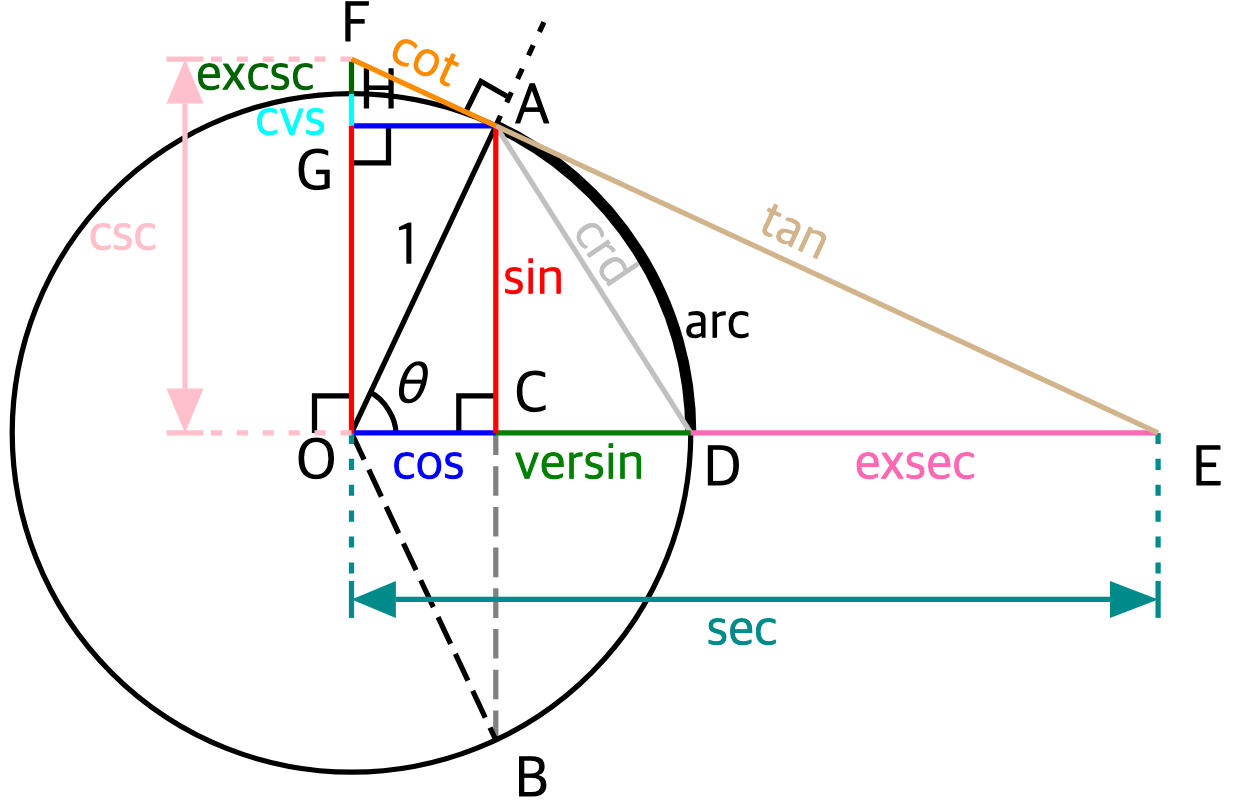

#### 아래와 같은 공식을 사용했다.
- tqdm 라이브러리를 활용하여 계산이 진행되는 현황을 확인했다.


In [ ]:
from geopy.distance import geodesic
from tqdm import tqdm
import pandas as pd

def calculate_distance(row):
    try:
        return geodesic((row['Latitude'], row['Longitude']), (row['역세권위도'], row['역세권경도'])).kilometers
    except (ValueError, TypeError):
        return None

# Create a new column with calculated distances
tqdm.pandas()  # Enable tqdm on pandas operations
df['역세권 개수'] = df.progress_apply(calculate_distance, axis=1)

df.head()

### 2-3. 결측값 처리
- 위도경도를 통해 데이터의 거리를 구하였고 null값을 도메인 지식을 통해서 어느정도 해결하였다.
- e.g) 강남구 전세의 경우 약 75%가 아파트임. 결측값을 평균으로 넣을 경우 문제가 생김. 
- 이에따라 각 전세구분(아파트, 오피스텔, 단독다가구, 연립주택)으로 나눠 평균을 구함.


### 2-4. 거리데이터 사용하기
- 거리를 막상 구하고 나니 이 거리데이터를 어떻게 활용해야할지 막막했다.
- 조인을 해야할것은 알겠는데 거리를 최대한 활용하기 위해서는 전략이 중요했다.
- 예를들면 우리가 지금 중요시여기는 것은 스타벅스와 전세집과의 거리 혹은 얼마나 있는가이다.
- 개별 집과 스타벅스의 거리만을 중요시여기기에는 banding이 되어있지않아 경향과 분포를 알기 어려울 것 같았다.
- 따라서 개별 집에서 그 근방 500m에 인프라가 얼마나있는지에 집중하기로 했다.
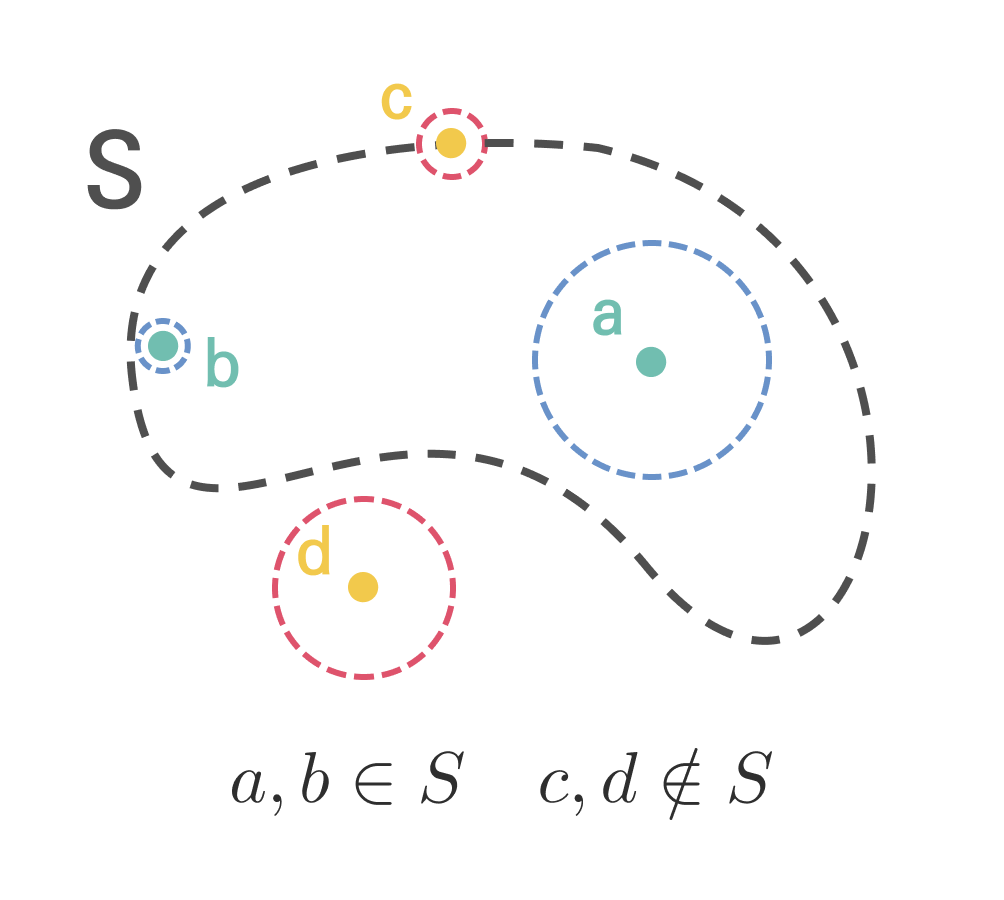

- 이에 따라 거리데이터는 있고 개업일자와 폐업일자가 없는 데이터는 cross join을 한뒤 grouby를 하여 merge했고
- 거리 데이터와 개업일자, 폐업일자가 모두 있는 데이터는 NON-EQUI JOIN(비등가 조인)을 진행하였다. 서로같지 않더라도 서로가 지정한 범주에 속하는 관계면 join을 하기 위함이다. 각각의 코드는 다음과 같다.

In [ ]:
# cross join
